# AT2 - Retail dataset preperation and modelling for Forecasting - Prophet

# 1. Loading the dataset

## 1.1. Launch commands to automatically reload modules

In [1]:
%load_ext autoreload
%autoreload 2

## 1.2. Import the packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To ensure plots are displayed in Jupyter notebooks
%matplotlib inline

## 1.3. Load the training and test dataset into a dataframes

In [3]:
# Load the training and test datasets into data frames 
# Load the Parquet files into DataFrames
df_train = pd.read_parquet('../../data/interim/price_merged_train_data.parquet')
df_test = pd.read_parquet('../../data/interim/price_merged_test_data.parquet')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        object        
 2   dept_id        object        
 3   cat_id         object        
 4   store_id       object        
 5   state_id       object        
 6   d              object        
 7   sales          int64         
 8   date           datetime64[ns]
 9   wm_yr_wk       int64         
 10  day_index      int64         
 11  day_name       object        
 12  month          int32         
 13  event_type     object        
 14  sell_price     float64       
 15  sales_revenue  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(9)
memory usage: 4.0+ GB


# 2.0 Data Preperation 

 ## 2.1 Installing the custom package with pip

In [5]:
! pip install -i https://test.pypi.org/simple/ my_krml_pine==2024.0.1.18

Looking in indexes: https://test.pypi.org/simple/


## 2.2 import custom functions

In [6]:
from my_krml_pine.models.null import NullRegressor
from my_krml_pine.models.performance import plot_regressor_scores
from my_krml_pine.data.datavisuals import plot_time_series
from my_krml_pine.models.evaluation import time_series_analysis

## 2.3 Visualising the dataset

### 2.3.1 visualising the sales over time

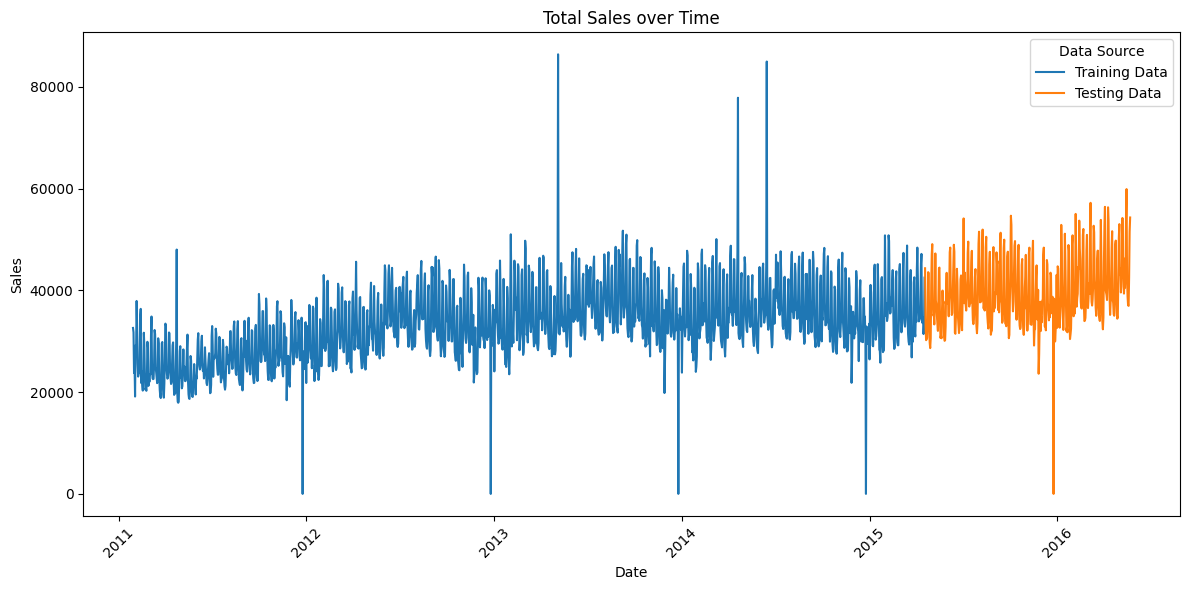

In [7]:
plot_time_series(df_train, 'date', 'sales', df_test, title='Total Sales over Time', xlabel='Date', ylabel='Sales')


## 2.4 Feature Selection 

In [8]:
#Feature selection. Since the model is to predict the sales given date, item and store, choosing to have 
# 'day_name', 'month','store_id','debt_id'(which can be extracted from item_id later when captured thru UI)
columns_to_drop = ['id','item_id','cat_id','state_id','d','wm_yr_wk','day_index','sell_price','sales','event_type','dept_id','store_id','day_name','month']
df_train = df_train.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   sales_revenue  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 531.2 MB


In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160986 entries, 0 to 12160985
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   sales_revenue  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 185.6 MB


## 2.5 Statistical Analysis

### 2.5.1 ADF and KPSS test

In [11]:
time_series_analysis(df_train['sales_revenue'], kpss_regression='ct')

Time Series Statistical Analysis Results:
-----------------------------------------
ADF Statistic: -8.439648284758556
ADF p-value: 1.7774596658048296e-13
ADF Critical Values: {'1%': -3.4316664347445838, '5%': -2.862121721032689, '10%': -2.5670796509438927}
-----------------------------------------
KPSS Statistic: 1.9762533904577362
KPSS p-value: 0.01
KPSS Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
-----------------------------------------


C:\Users\paiyn\AppData\Local\pypoetry\Cache\virtualenvs\kaggle1-nbadraft-risGQE3a-py3.11\Lib\site-packages\my_krml_pine\models\evaluation.py:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression=kpss_regression)


*** When using the Prophet model, it’s not strictly necessary to make your time series stationary, as Prophet is designed to handle trends and seasonality in the data without requiring stationarity. \
*** So not doing any more data preparation for modelling

### 2.5.2 Rolling mean and variance

In [12]:
 # setting as 30 to get monthly rolling statistics
window_size = 30 

# Calculate the rolling mean
rolling_mean = df_train['sales_revenue'].rolling(window=window_size).mean()

# Calculate the rolling variance
rolling_variance = df_train['sales_revenue'].rolling(window=window_size).var()

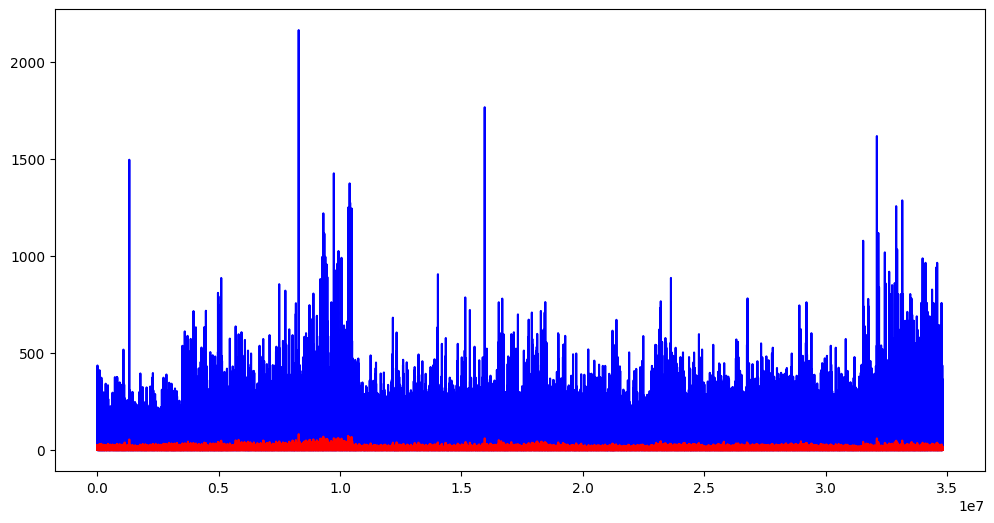

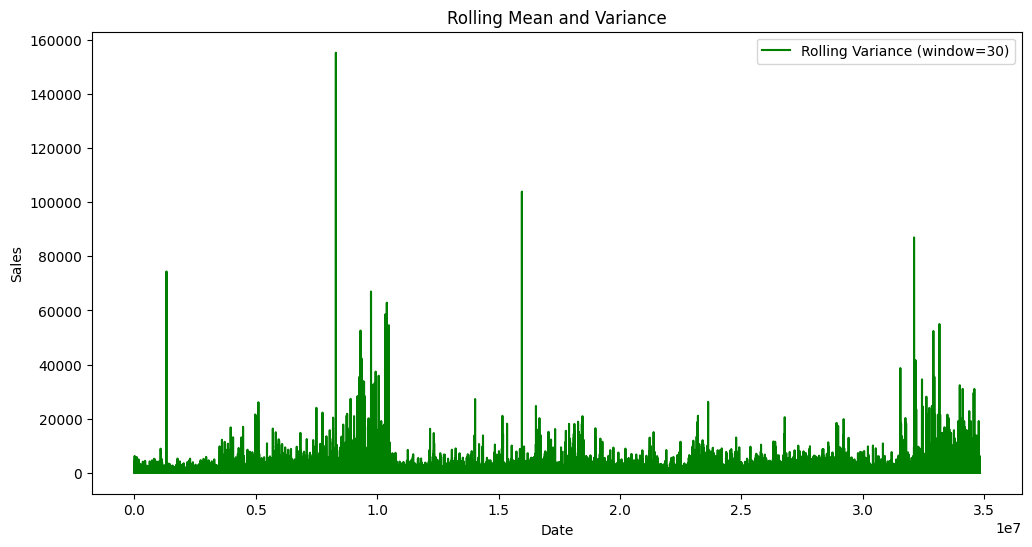

In [13]:
plt.figure(figsize=(12, 6))

# Plot the original sales data
plt.plot(df_train['sales_revenue'], label='Original Sales', color='blue')

# Plot the rolling mean
plt.plot(rolling_mean, label=f'Rolling Mean (window={window_size})', color='red')

# Create another plot for rolling variance
plt.figure(figsize=(12, 6))
plt.plot(rolling_variance, label=f'Rolling Variance (window={window_size})', color='green')

# Add titles and labels
plt.title('Rolling Mean and Variance')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add legends
plt.legend(loc='best')

# Show the plots
plt.show()

## 2.6 Feature Engineering

In [14]:
## Since the business problem is to predict the total sales revenue across all stores and items, we need to find the total revenue on a given date
# Consolidate total revenue by date
df_train_total = df_train.groupby('date')['sales_revenue'].sum().reset_index()
X_test_total = X_test.groupby('date')['sales_revenue'].sum().reset_index()

# Rename columns for clarity
df_train_total.columns = ['date', 'total_revenue']
X_test_total.columns = ['date', 'total_revenue']

# 3.0 Modelling and measuring model performance

In [15]:
# import package
from prophet import Prophet

C:\Users\paiyn\AppData\Local\pypoetry\Cache\virtualenvs\kaggle1-nbadraft-risGQE3a-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [16]:
# Prepare data for Prophet by renaming the columns that is defined for prophet model
df = df_train_total.reset_index().rename(columns={'date': 'ds', 'total_revenue': 'y'})
df_test = X_test_total.reset_index().rename(columns={'date': 'ds', 'total_revenue': 'y'})

# Initialize and fit the model
Prof_model = Prophet()
Prof_model.fit(df)

12:16:54 - cmdstanpy - INFO - Chain [1] start processing
12:16:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE Train: 10377.08
MAE Train: 6731.14
Mean Percentage Difference Train: 779.08%


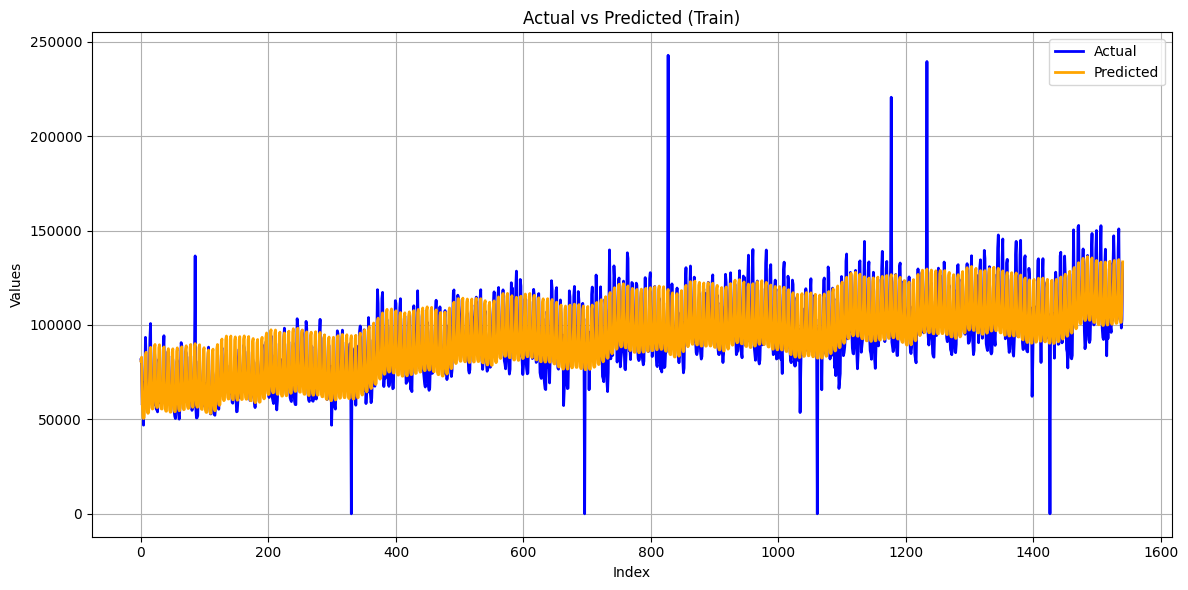

In [17]:
# use the model to make a forecast
forecast_train = Prof_model.predict(df)

# calculate MAE between expected and predicted values for december
y_true = df['y'].values
y_pred = forecast_train['yhat'].values

# print the performance scores
plot_regressor_scores(y_preds=y_pred, y_actuals=y_true, set_name='Train')


RMSE Test: 14155.57
MAE Test: 10299.23
Mean Percentage Difference Test: 906.27%


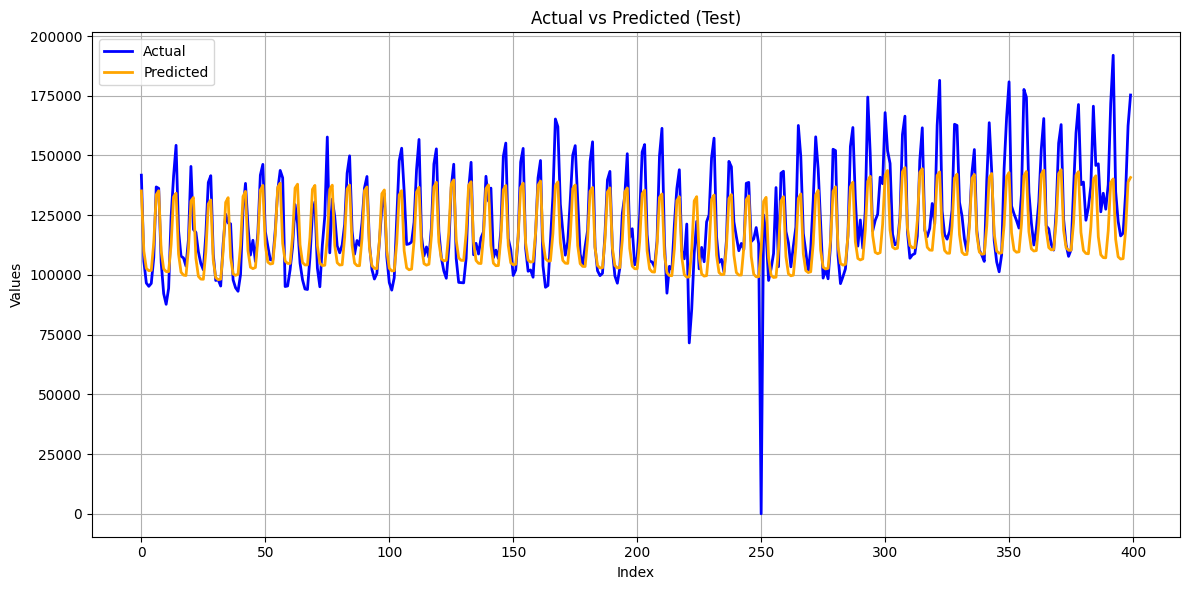

In [18]:
# use the model to make a forecast
forecast_test = Prof_model.predict(df_test)

# calculate MAE between expected and predicted values for december
y_true = df_test['y'].values
y_pred = forecast_test['yhat'].values

# print the performance scores
plot_regressor_scores(y_preds=y_pred, y_actuals=y_true, set_name='Test')


In [19]:
# Save the model 
# Import dump from joblib package and save Prof_model into models folder
from joblib import dump

dump(Prof_model,  '../../models/Forecasting/Prof_model.joblib')

['../../models/Predictive/Prof_model.joblib']

# 4.0 Hyperparameter tuning

In [20]:
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
cutoffs = pd.to_datetime(['2014-01-01', '2014-06-01', '2015-01-01', '2015-04-01'])


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:59 - cmdstanpy - INFO - Chain [1] start processing
12:16:59 - cmdstanpy - INFO - Chain [1] done processing
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:06 - cmdstanpy - INFO - Chain [1] start processing
12:17:06 - cmdstanpy - INFO - Chain [1] done processing
12:17:08 - cmdstanpy - INFO - Chain [1] start processing
12:17:08 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:13 - cmdstanpy - INFO - Chain [1] start processing
12:17:13 - cmdstanpy - INFO - Chain [1] done processing
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01   7283.733251
1                     0.001                     0.10   7316.198318
2                     0.001                     1.00   7374.700489
3                     0.001                    10.00   7407.192070
4                     0.010                     0.01   9577.679513
5                     0.010                     0.10   9658.276910
6                     0.010                     1.00   9646.093119
7                     0.010                    10.00   9573.043639
8                     0.100                     0.01  10173.974294
9                     0.100                     0.10  10183.994884
10                    0.100                     1.00  10168.019545
11                    0.100                    10.00  10148.895777
12                    0.500                     0.01  10674.931074
13                    0.500                     0.10  10649.98

In [21]:
# Print the best params
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


# 5.0 Model fitting using identified hyper parameters

In [22]:
# Initialize and fit the model
Prof_model1 = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)
Prof_model1.fit(df)

12:17:39 - cmdstanpy - INFO - Chain [1] start processing
12:17:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE Train: 10973.25
MAE Train: 7382.94
Mean Percentage Difference Train: 777.06%


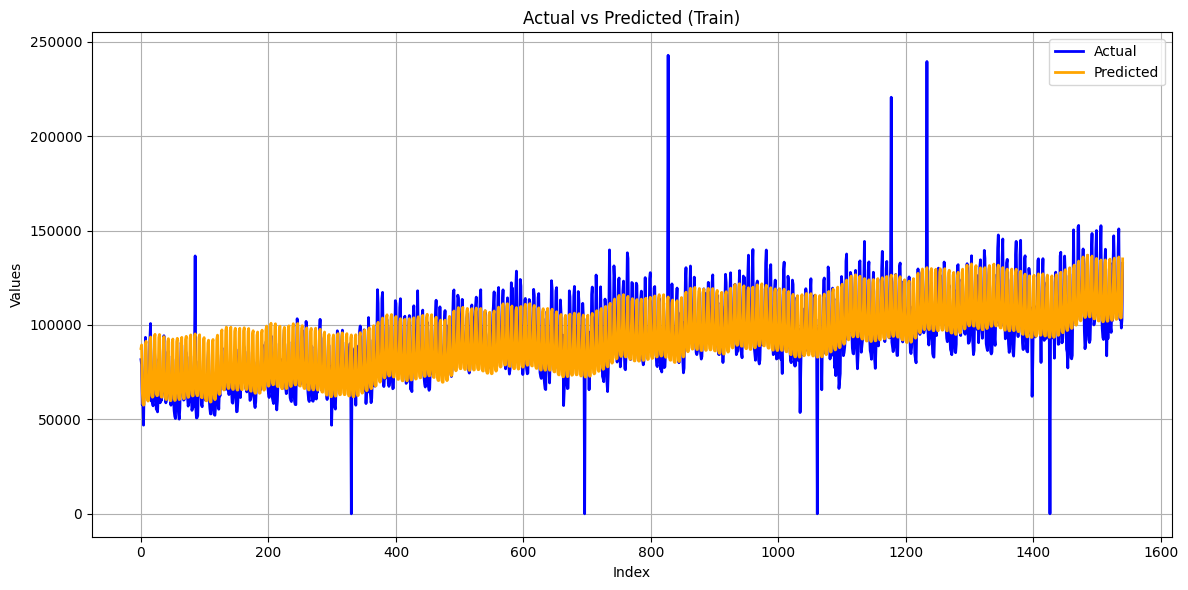

In [23]:
# use the model to make a forecast
forecast_train = Prof_model1.predict(df)

# calculate MAE between expected and predicted values for december
y_true = df['y'].values
y_pred = forecast_train['yhat'].values

# print the performance scores
plot_regressor_scores(y_preds=y_pred, y_actuals=y_true, set_name='Train')

RMSE Test: 12964.48
MAE Test: 9140.22
Mean Percentage Difference Test: 942.35%


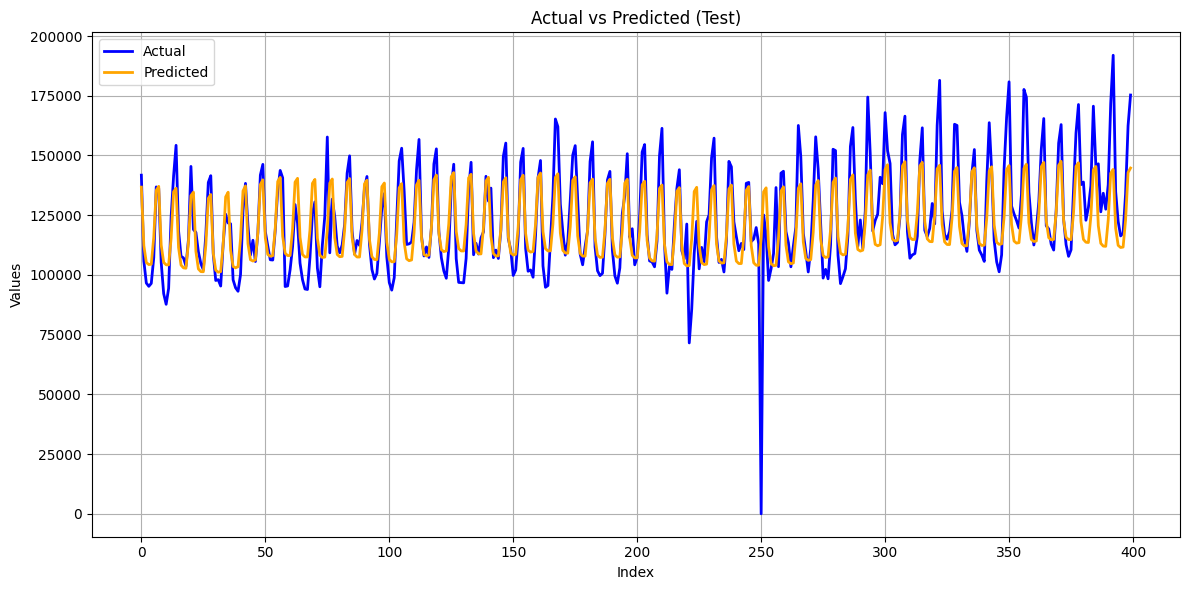

In [24]:
# use the model to make a forecast
forecast_test = Prof_model1.predict(df_test)

# calculate MAE between expected and predicted values for december
y_true = df_test['y'].values
y_pred = forecast_test['yhat'].values

# print the performance scores
plot_regressor_scores(y_preds=y_pred, y_actuals=y_true, set_name='Test')

The fact that the test RMSE (12964.48) is higher than the training RMSE (10973.25) suggests that the model may not generalize well to new data, which could indicate overfitting.\
*** High percentage values (especially over 100%) indicate that, on average, your predictions are significantly off from the actual values.\
*** The increase from the training (777.06%) to test set (942.35%) indicates that the model's predictions are disproportionately worse when applied to unseen data

In [25]:
# Save the model 

dump(Prof_model1,  '../../models/Forecasting/Prof_model1.joblib')

['../../models/Predictive/Prof_model1.joblib']